# Import Libraries

In [1]:
import os
import pandas as pd
import glob
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import torch
import gc
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix

from misl_dataset import train_valid_test_split

In [29]:
!python ./test_kasra.py

I work


In [2]:
device = torch.device('cpu')
gc.collect()

0

## Extracting the Patches from the WSI

In [ ]:
!python ./extract_patches.py

## VGG-16 Feature Extraction

In [ ]:
!python ./vgg16_feature_extraction.py

## K-Means Clustering

In [2]:
def K_means_clustering(feature, k):
    feature = np.array(feature)
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(feature)
    with open("Existing_model.pkl", "wb") as f:
        pickle.dump(kmeans, f)
    cluster_assignments = kmeans.labels_
    centroid = kmeans.cluster_centers_
     
    # Calculating the sum of the intra-cluster distances
    inertia = kmeans.inertia_
    return cluster_assignments, inertia, centroid

vgg_features = []
pid = []
patient_path = './new_csv/'
patient_list =  os.listdir(patient_path)
patient_list.pop(patient_list.index('.DS_Store'))
for name in patient_list:
    df = pd.read_csv(os.path.join(patient_path, name))
    name = name.lower()
    pid.append([name[:12]] * len(df))
    vgg_features.append(df)
vgg_features = pd.concat(vgg_features, ignore_index = True)
pid = sum(pid, [])

vgg_features = vgg_features.drop(columns = "Unnamed: 0")

if os.path.exists("./Existing_cluster,pkl"):
    with open("Existing_model.pkl", "rb") as f:
        existing_model = pickle.load(f)
    
    cluster_assign = existing_model.predict(vgg_features)
    
else:
    cluster_assign, performance, centroid = K_means_clustering(feature = vgg_features, k = 10)

print(cluster_assign.shape)

SyntaxError: expected ':' (2866660155.py, line 12)

In [ ]:
vgg_features['cluster_num'] = cluster_assign
vgg_features['pid'] = pid

vgg_features.to_csv('clustered_data.csv', index = False)

## Classifier

Constants

In [3]:
epochs = 30
batch_size = 1
lr = 0.001
num_clusters = 10

# Model Definition

In [4]:
import torch.nn as nn
import torch

class DeepAttnMIL_Surv(nn.Module):
    """
    Deep AttnMISL Model definition
    """
    def __init__(self, cluster_num):
        super(DeepAttnMIL_Surv, self).__init__()
        self.embedding_net = nn.Sequential(nn.Conv1d(1000, 64, 1),
                                     nn.ReLU(),
                                     nn.AdaptiveAvgPool1d(1)
                                     )

        self.attention = nn.Sequential(
            nn.Linear(64, 32), # V
            nn.Tanh(),
            nn.Linear(32, 1)  # W
        )

        self.fc6 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(32,2)
        )
        self.cluster_num = cluster_num

    def masked_softmax(self, x, mask=None):
        """
        Performs masked softmax, as simply masking post-softmax can be
        inaccurate
        :param x: [batch_size, num_items]
        :param mask: [batch_size, num_items]
        :return:
        """
        if mask is not None:
            mask = mask.float()
        if mask is not None:
            x_masked = x * mask + (1 - 1 / (mask+1e-5))
        else:
            x_masked = x
        x_max = x_masked.max(1)[0]
        x_exp = (x - x_max.unsqueeze(-1)).exp()
        if mask is not None:
            x_exp = x_exp * mask.float()
        return x_exp / x_exp.sum(1).unsqueeze(-1)

    def forward(self, x, mask):

        " x is a tensor list"
        res = []
        for i in range(self.cluster_num):
                
            hh = x[i]
            
            hh = hh.unsqueeze(0).reshape(1, 1000, len(hh))
            
            output = self.embedding_net(hh)
            
            output = output.view(output.size()[0], -1)
            
            res.append(output)

        h = torch.cat(res)

        b = h.size(0)
        c = h.size(1)

        h = h.view(b, c)
        
        A = self.attention(h)
        A = torch.transpose(A, 1, 0)  # KxN
        
        A = self.masked_softmax(A, mask)

        M = torch.mm(A, h)  # KxL

        Y_pred = self.fc6(M)

        return Y_pred

In [11]:
sample_model = DeepAttnMIL_Surv(cluster_num=10)
torch.save(sample_model.state_dict(), 'initial_model.pt')

# Loading Dataset

In [5]:
data_path = './clustered_data.csv'
label_path = './BRCA_stages.csv'

train_data, valid_data, test_data = train_valid_test_split(data_path, label_path, 0.2, 0.2)

<built-in function len>
test stage values: stage ii    19
stage i     15
Name: stage, dtype: int64
train stage values: stage ii    94
stage i     75
Name: stage, dtype: int64
validation stage values: stage ii    15
stage i     12
Name: stage, dtype: int64


/Users/kasraborazjani/Desktop/UB/Spring 2023/CSE573 Course Project/CSE573-Final-Project/misl_dataset.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.labels['stage'] = self.labels.stage.map(lambda x: one_hot_binary(x))


Training the Model

In [13]:
model = DeepAttnMIL_Surv(cluster_num = num_clusters).to(device)
model.load_state_dict(torch.load('initial_model.pt'))
model.train()

train_loss = []
loss_valid = []
acc_val = []
acc_train = []
best_loss = float('inf')
patience = 7

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = 0.005, momentum = 0.9)

def predict(batch, label):
    patient, mask = batch
    for cluster_id in range(len(patient)):
        patient[cluster_id] = patient[cluster_id].to(device)
    mask = mask.to(device)
    label = label.to(device)

    output = model(patient, mask)
    label.unsqueeze_(0)
    loss = criterion(output, label)
    output = output.to("cpu")
    y_pred = np.argmax(np.array(output), axis = 1)
    label = label.to("cpu")
    label = np.argmax(label, axis = 1)
    acc = accuracy(y_pred, label) 
    return {'loss': loss, 'acc': acc}

def accuracy(y_pred, labels):
    return np.sum(y_pred == labels.numpy()) / labels.shape[0] * 100

for i in range(epochs):
    epoch_loss = []
    for batch_idx, (batch, label) in enumerate(train_data):
        patient, mask = batch
        for cluster_id in range(len(patient)):
            patient[cluster_id] = patient[cluster_id].to(device)
        label = label.to(device)
        mask = mask.to(device)

        output = model(patient, mask)

        label.unsqueeze_(0)
        loss = criterion(output, label)
        epoch_loss.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = torch.stack(epoch_loss)
    epoch_loss = epoch_loss.to("cpu").detach().numpy().mean()
    train_loss.append(epoch_loss)

    if i % 10 == 0:
        print(f'Epoch: {i} ---> Epoch Loss: {epoch_loss}')

    with torch.no_grad():
        train_op = [predict(batch, label) for batch_idx, (batch, label) in enumerate(train_data)]
        train_acc = [x['acc'] for x in train_op]
        acc_train.append((np.array(train_acc)).mean())
        
        valid_op = [predict(batch, label) for batch_idx, (batch, label) in enumerate(valid_data)]
        batch_losses = [x['loss'] for x in valid_op]
        valid_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['acc'] for x in valid_op]
        valid_acc = (np.array(batch_accs)).mean()
        acc_val.append(valid_acc)
        loss_valid.append(valid_loss)
        if i % 10 == 0:
            print(f"epoch: {i}, Validation loss: {valid_loss}, Validation Accuracy: {valid_acc}%")
    
    # Performing Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model = model.state_dict()
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print(f"Validation loss hasn't improved in {patience} epochs. Stopping early!!!")
            break

Epoch: 0 ---> Epoch Loss: 0.7078738212585449
epoch: 0, Validation loss: 0.6843231916427612, Validation Accuracy: 59.25925925925926%
epoch: 1, Validation loss: 0.6824985146522522, Validation Accuracy: 55.55555555555556%
epoch: 2, Validation loss: 0.6764241456985474, Validation Accuracy: 59.25925925925926%
epoch: 3, Validation loss: 0.6702436804771423, Validation Accuracy: 59.25925925925926%
epoch: 4, Validation loss: 0.6733582615852356, Validation Accuracy: 59.25925925925926%
epoch: 5, Validation loss: 0.6736778020858765, Validation Accuracy: 59.25925925925926%
epoch: 6, Validation loss: 0.6583266258239746, Validation Accuracy: 59.25925925925926%
epoch: 7, Validation loss: 0.6434166431427002, Validation Accuracy: 59.25925925925926%
epoch: 8, Validation loss: 0.6479774117469788, Validation Accuracy: 59.25925925925926%
epoch: 9, Validation loss: 0.6167133450508118, Validation Accuracy: 70.37037037037037%
Epoch: 10 ---> Epoch Loss: 0.635219156742096
epoch: 10, Validation loss: 0.6223644614

Testing the Model

In [14]:

# create a new instance of your model
model_test = DeepAttnMIL_Surv(num_clusters).to(device)

# load the best_model weights into the new instance
model_test.load_state_dict(best_model)

# set the model to evaluation mode
model_test.eval()

def test_predict(batch, label):
    patient, mask = batch
    for cluster_id in range(len(patient)):
        patient[cluster_id] = patient[cluster_id].to(device)
    mask = mask.to(device)
    label = label.to(device)

    output = model_test(patient, mask)
    label.unsqueeze_(0)
    loss = criterion(output, label)
    output = output.to("cpu")
    y_pred = np.argmax(np.array(output), axis = 1)
    label = label.to("cpu")
    label = np.argmax(label, axis = 1)
    acc = accuracy(y_pred, label) 
    return {'loss': loss, 'acc': acc, 'pred': y_pred, 'true': label}

with torch.no_grad():
    test_op = [test_predict(batch, label) for batch_idx, (batch, label) in enumerate(test_data)]
    batch_losses = [x['loss'] for x in test_op]
    test_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['acc'] for x in test_op]
    test_acc = (np.array(batch_accs)).mean()

print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}')

Test Loss: 0.8206048011779785, Test Accuracy: 82.3529411764706


Plotting Loss

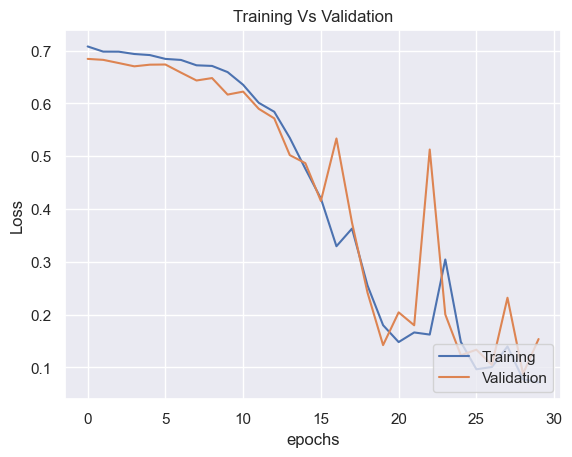

In [31]:
sns.set(style = "darkgrid") # Background Theme

plt.plot(train_loss)
# loss_valid = torch.stack(loss_valid)
# loss_valid = loss_valid.to('cpu')
plt.plot(loss_valid)
plt.legend(["Training", "Validation"], loc ="lower right")
plt.xlabel("epochs")
plt.title("Training Vs Validation")
plt.ylabel("Loss")
plt.savefig('./train_val_loss.png')

Plotting Accuracy

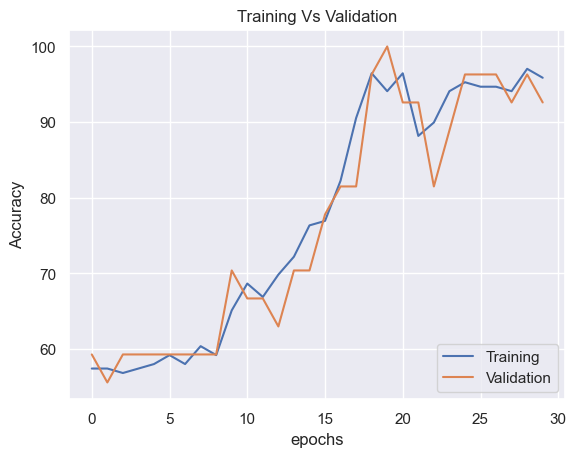

In [32]:
plt.plot(acc_train)
plt.plot(acc_val)
plt.legend(["Training", "Validation"], loc ="lower right")
plt.xlabel("epochs")
plt.title("Training Vs Validation")
plt.ylabel("Accuracy")
plt.savefig('train_val_acc.png')

Confusion Matrix

In [17]:
pred = np.array([x['pred'] for x in test_op])
true = np.stack([x['true'] for x in test_op])

array([[1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1]])

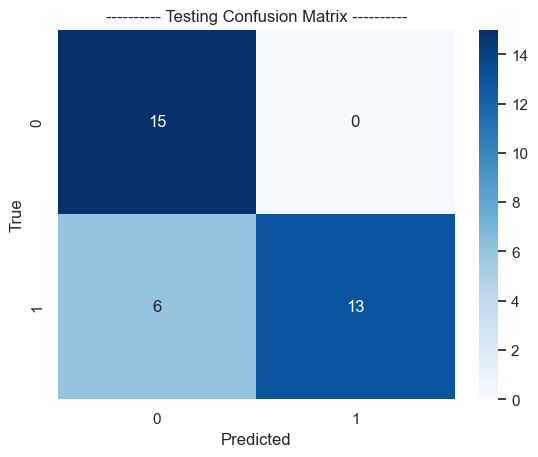

In [37]:
cm = confusion_matrix(true, pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("---------- Testing Confusion Matrix ----------")
# plt.show()
plt.savefig('./conf_mat.png')

In [38]:
from sklearn.metrics import f1_score, recall_score, precision_score

print("F1 score: {}".format(f1_score(true, pred)))
print("Recall: {}".format(recall_score(true, pred)))
print("Precision score: {}".format(precision_score(true, pred)))

F1 score: 0.8125000000000001
Recall: 0.6842105263157895
Precision score: 1.0
